In [11]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [12]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [13]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


In [14]:
train_folders

['notMNIST_large\\A',
 'notMNIST_large\\B',
 'notMNIST_large\\C',
 'notMNIST_large\\D',
 'notMNIST_large\\E',
 'notMNIST_large\\F',
 'notMNIST_large\\G',
 'notMNIST_large\\H',
 'notMNIST_large\\I',
 'notMNIST_large\\J']

In [15]:
test_folders

['notMNIST_small\\A',
 'notMNIST_small\\B',
 'notMNIST_small\\C',
 'notMNIST_small\\D',
 'notMNIST_small\\E',
 'notMNIST_small\\F',
 'notMNIST_small\\G',
 'notMNIST_small\\H',
 'notMNIST_small\\I',
 'notMNIST_small\\J']

In [16]:
import os, random
dir_name = "notMNIST_large"
folder_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
for folder in folder_names:
    im_name = random.choice(os.listdir(dir_name + "/" + folder))
    im_file = dir_name + "/" + folder + "/" + im_name
    display(Image(filename=im_file))

In [17]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  image_index = 0
  print(folder)
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset


def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
est_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
notMNIST_large\J.pickle already present - Skipping pickling.
notMNIST_small\A.pickle already present - Skipping pickling.
notMNIST_small\B.pickle already present - Skipping pickling.
notMNIST_small\C.pickle already present - Skipping pickling.
notMNIST_small\D.pickle already present - Skipping pickling.
notMNIST_small\E.pickle already present - Skipping pickling.
notMNIST_small\F.pickle already present - Skipping pickling.
notMNIST_small\G.pickle 

[[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.45294118 -0.45686275 -0.49607843
  -0.5        -0.46470588 -0.48039216 -0.5        -0.49607843 -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.44117647 -0.40980393 -0.17843138
  -0.04509804 -0.26078433 -0.1509804  -0.35882354 -0.5        -0.49607843
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.49215686 -0.5        -0.2254902   0.11960784  0.26862746
   0.5         0.37058824  0.38627452 -0.01372549 -0.37843138 -0.49215686
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5  

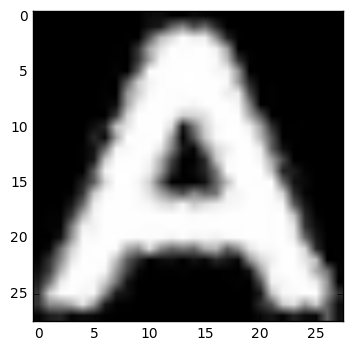

In [18]:
with open('notMNIST_small/A.pickle', 'rb') as f:
        letter_set_A = pickle.load(f)
imgplot = plt.imshow(letter_set_A[0], cmap='Greys_r')
print(letter_set_A[0])
plt.show()

In [19]:
for label, pickle_file in enumerate(train_datasets):
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        print(letter_set.shape)
        
for label, pickle_file in enumerate(test_datasets):
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        print(letter_set.shape)

(52909, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52911, 28, 28)
(1872, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)


In [20]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [21]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)


In [22]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [23]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800503


In [27]:
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
    all_data = pickle.load(f)

# Logistic CLassifier object
logclass = LogisticRegression()

train_reshape = all_data['train_dataset'].reshape(all_data['train_dataset'].shape[0],-1)
logclass.fit(train_reshape[0:50,:], all_data['train_labels'][0:50])

print ('Coefficients: \n', logclass.coef_)

test_reshape = all_data['test_dataset'].reshape(all_data['test_dataset'].shape[0], -1)
print(logclass.predict(test_reshape[0:50,:]))
print(all_data['test_labels'][0:50])


Coefficients: 
 [[ 0.08347928  0.06174405  0.09543751 ...,  0.19490244  0.1863111
   0.1835611 ]
 [ 0.15655703  0.13697437  0.18789142 ...,  0.12404838  0.16942678
   0.19555573]
 [ 0.07614334  0.06219991  0.10503586 ...,  0.11396749  0.1112885
   0.13232293]
 ..., 
 [ 0.13675904  0.11069455  0.08297274 ...,  0.10328183  0.15586142
   0.17895027]
 [ 0.10845122  0.13568847  0.14175835 ...,  0.10825633  0.09970206
   0.08842163]
 [ 0.12296591  0.08103541  0.11598039 ...,  0.10315091  0.08048395
   0.10659384]]
[1 6 4 4 7 1 7 1 4 4 1 0 9 5 0 5 6 8 6 7 6 8 0 6 4 6 1 0 2 6 0 4 8 6 1 1 5
 4 1 8 4 7 1 8 6 6 4 6 7 4]
[3 6 4 7 7 7 7 1 7 4 6 0 9 0 0 2 2 8 2 9 8 8 7 6 5 2 2 0 2 6 0 1 8 6 1 3 5
 7 3 9 3 1 1 8 2 3 1 2 7 2]


In [28]:
test_reshape = all_data['test_dataset'].reshape(all_data['test_dataset'].shape[0], -1)
print(logclass.predict(test_reshape[0:20,:]))
print(all_data['test_labels'][0:20])

[1 6 4 4 7 1 7 1 4 4 1 0 9 5 0 5 6 8 6 7]
[3 6 4 7 7 7 7 1 7 4 6 0 9 0 0 2 2 8 2 9]
